##  UltraSonicSensorAnalysis Jupyter notebook - PyTorch version


### Our goal is to predict the reflected (Echo) signal using other, more readily available, transducer parameters.  We will use Frequency, Ring-down, and Excitation voltage to predict Echo signal amplitude.  

### Of course for training and testing, we need reflected echo signal intensity, but after this is done once, device echo intensity can be inferred from parameters measured in the socket only.  

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

import torch
import torch.nn as nn
import torch.optim as optim

import time
from tqdm import tqdm

### Read in the data and create the training and test data sets

### Training and test data are selected randomly here, and could affect your results. Occasionally, even though the testing die data is not intermixed with the training die data, at times the testing loss is a little lower than the training loss. Just the luck of the (data) draw...  

In [33]:
# There are up to 10 measurements for each Die ID, and we need to keep these 10 measurements together so the 
# training and test sets have no cross-talk or "contamination".  In other words, 10 measurements for a given
# Die ID will all be either training or test measurements. 

# Here is the strategy:
# 1) Get all the unique Die IDs
# 2) Split the Die IDs into train IDs and test IDs
# 3) Create a test data frame from the test IDs and a train data frame from the train IDs

# First, read in the data from the "data" subfolder:
df = pd.read_csv('../data/test_data.csv')

# Here are all the unique Die IDs
die_ids = np.unique(df['Die ID'])
print("Unique Die IDs found:", len(die_ids))

# Here is the training fraction
train_frac = 0.75

# Now create a random list of the Die IDs to be used for training
train_ids = np.random.choice(die_ids, size=int(train_frac*len(die_ids)), replace=False)
print("Number of training Die IDs:", len(train_ids))

# Now here are the Die IDs to be used for testing - just get what wasn't used for training
test_ids = np.setdiff1d(die_ids, train_ids)
print("Number of testing Die IDs:", len(test_ids))
print()

# Confirm no training Die IDs are intermixed with testing Die IDs:
if (np.intersect1d(train_ids, test_ids, assume_unique=False, return_indices=False).size > 0):
    print("Testing and training Die IDs appear to be intermixed!!")
else:
    print("No crosstalk between training and testing Die IDs.")

    
# Here, create the test and train data frames based on the Die IDs
test_df = pd.DataFrame()
train_df = pd.DataFrame()
junk = pd.DataFrame()

for tstid in test_ids:
    junk = df[ df['Die ID'] == tstid  ]
    #test_df = test_df.append(junk)
    test_df = pd.concat([test_df, junk], axis=0)

for trainid in train_ids:
    junk = df[ df['Die ID'] == trainid  ]
    #train_df = train_df.append(junk)
    train_df = pd.concat([train_df, junk], axis=0)
    
#print(test_df.shape, train_df.shape)
#print("Total number of rows:", train_df.shape[0] + test_df.shape[0])


# Split the train and test data into features (X) and labels (y):
X_train = train_df[['Frequency', 'Ring-down','Excitation']]
y_train = train_df['Echo']

X_test = test_df[['Frequency', 'Ring-down','Excitation']]
y_test = test_df['Echo']


# Probably not too critical in this case, but scale the features - better safe than sorry!
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert Pandas Series to np arrays - feature matrices are already in np form from the scale operation(s)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Finally, now convert all np array data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

Unique Die IDs found: 712
Number of training Die IDs: 534
Number of testing Die IDs: 178

No crosstalk between training and testing Die IDs.


###  Define a very simple PyTorch neural network model with relu activation
### Use same model topology, learning rate, batch size, epochs as was used for Keras notebook version

In [34]:
class simpleNN(nn.Module): 
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(X_train.shape[1], 6)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(6, 9)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(9, 1, bias=True)
    
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.output(x)
        return x

### Here, train the model with batches inside the epoch loop and test after each epoch.
### Log the training and testing loss history. 

In [35]:
# Instantiate the model
model = simpleNN()
#print(model)  # Uncomment this line to see network topology

# Set key hyperparameters - same as those used for Keras version:
learning_rate = 0.001
n_epochs = 250
batch_size = 64

loss_metric = nn.MSELoss() # Use MSE - same as Keras
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 

# Create empty lists to hold loss histories
train_loss_hist = []
test_loss_hist = []

for epoch in tqdm(range(n_epochs), desc='Train/test progress'):
    for i in range(0, len(X_train), batch_size):
        X_train_batch = X_train[i:i+batch_size]
        y_pred = model(X_train_batch)
        y_train_batch = y_train[i:i+batch_size]
        train_loss = loss_metric(y_pred, y_train_batch)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
    # After each epoch, get the test loss
    with torch.no_grad():
        predictions = model(X_test)
        train_loss_hist.append(train_loss.detach())
        test_loss = loss_metric(predictions, y_test)
        test_loss_hist.append(test_loss.detach())
    

Train/test progress: 100%|████████████████████| 250/250 [00:13<00:00, 19.22it/s]


### Using the test data set, test the model and see how it compares to the ground truth values

### Plot predicted versus measured results

Slope: 0.86    Offset: 842.2


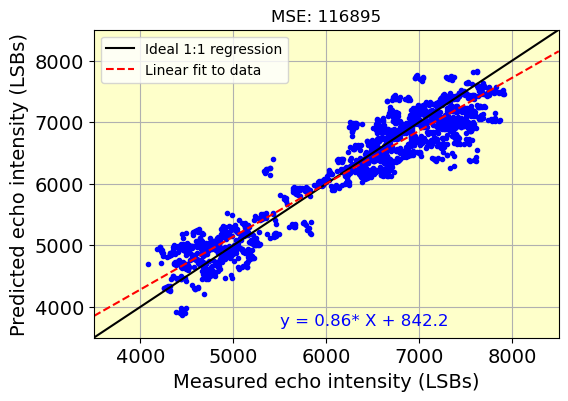

In [36]:
# Here are the predicted amplitudes of the test die
predictions = model(X_test)

# Calculate MSE
mse = round(mean_squared_error(y_test.detach().numpy(), predictions.detach().numpy()) )

fig = plt.figure(figsize=(6, 4))
fig.add_subplot(111)

# Scale the graph axes
the_start = 3500
the_end = 8500

# Plot predicted versus measured amplitude:
plt.plot(y_test.detach(), predictions.detach(), "b.")
plt.title(f'MSE: {mse}')

# Perfect prediction - a solid black line denotes the 1:1 regression
plt.plot([the_start, the_end], [the_start, the_end],'k-', label="Ideal 1:1 regression")
plt.xlim(the_start, the_end)
plt.ylim(the_start, the_end)
ax = plt.gca()
ax.set_facecolor('#feffcA')
plt.grid()

plt.xlabel('Measured echo intensity (LSBs)', fontsize=14)
plt.ylabel('Predicted echo intensity (LSBs)', fontsize=14)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)


lin_reg = LinearRegression()
lin_reg.fit(np.array(y_test.detach()).reshape(-1, 1), predictions.detach())

slope = np.round(lin_reg.coef_[0][0], 3)
intercept = np.round(lin_reg.intercept_[0], 1)

# Here are intercept and slope of predicted vs. actual amplitude values
print("Slope:", slope, "   Offset:",intercept)

# Plot linear fit of the predicted amplitude versus measured:
plt.plot([the_start, the_end],
         [the_start*lin_reg.coef_[0][0] + lin_reg.intercept_[0] , 
          the_end*lin_reg.coef_[0][0] + lin_reg.intercept_[0] ], 'r--', label="Linear fit to data")

# Show the best linear fit slope and intercept:
plt.text(the_start + 2000, the_start + 200, 'y = '+str(slope)+"* X + " + str(intercept), fontsize=12,color = (0, 0, 1));
plt.legend(loc='upper left');


### Show the losses versus the epoch number

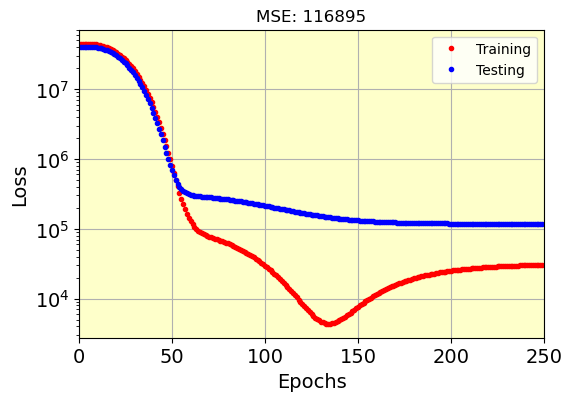

In [37]:
save_fig = False

fig = plt.figure(figsize=(6, 4))
fig.add_subplot(111)

# Plot the model loss over the training epochs

plt.semilogy(np.array(train_loss_hist).reshape(-1,1), 'r.', label='Training')
plt.semilogy(np.array(test_loss_hist).reshape(-1,1), 'b.', label='Testing')
#plt.semilogy(losses['val_loss'], 'b-', label='Validation')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title(f'MSE: {np.round(mse, 1)}')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
ax = plt.gca()

ax.set_facecolor('#feffcA')
plt.grid()
plt.xlim(0, n_epochs)
plt.legend();


if save_fig:
    fig = plt.gcf()
    fig_name = "Loss"
    fig.savefig("All_data" + fig_name)